In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pennylane as qml
from qlstm_pennylane import QLSTM
import pandas as pd

In [9]:
data=pd.read_csv('Sindata.csv')
data

,Wave
0,0.841471
1,0.873736
2,0.902554
3,0.927809
4,0.949402
...,...
4996,0.680667
4997,0.725324
4998,0.767118
4999,0.805885


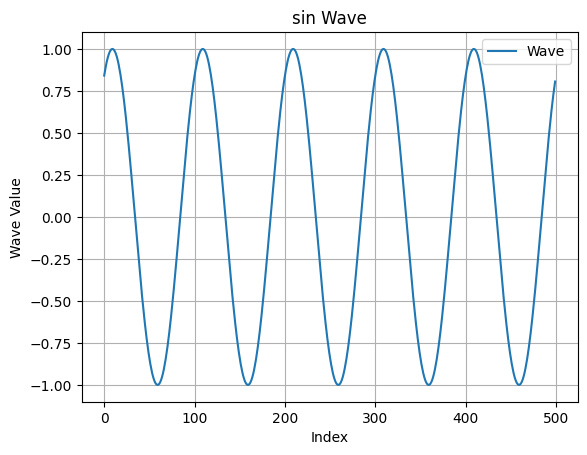

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

dataa = data["Wave"][:500]

# Plot the data
plt.plot(dataa, label="Wave")
plt.title("sin Wave")
plt.xlabel("Index")
plt.ylabel("Wave Value")
plt.legend()
plt.grid(True)
plt.show()


**Regression Model Using LSTM or QLSTM**

In [11]:
class LSTMSin(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_qubits=0, n_qlayers=1, n_layers=1, backend="default.qubit"):
        """
        If n_qubits > 0, we use the quantum-enhanced QLSTM.
        Otherwise, we use the classical nn.LSTM.
        """
        super(LSTMSin, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_qubits = n_qubits

        if n_qubits > 0:
            print("Sin Model will use Quantum LSTM (QLSTM)")
            self.lstm = QLSTM(
                input_size=input_dim, 
                hidden_size=hidden_dim, 
                n_qubits=n_qubits, 
                n_qlayers=n_qlayers, 
                batch_first=True,
                return_sequences=True, 
                return_state=True,
                backend=backend
            )
        else:
            print("Sin Model will use Classical LSTM")
            self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=n_layers, batch_first=True)
            
        # Map LSTM hidden state to single output (the regression value).
        self.hidden2out = nn.Linear(hidden_dim, 1)

    def forward(self, sequence):
        # sequence has shape: (batch_size, seq_length, input_dim)
        hidden_seq, state = self.lstm(sequence)
        output = self.hidden2out(hidden_seq)
        return output


In [12]:
df=data["Wave"][:500]

In [13]:
len(df)

500

In [15]:
df

0      0.841471
1      0.873736
2      0.902554
3      0.927809
4      0.949402
         ...   
495    0.633324
496    0.680667
497    0.725324
498    0.767118
499    0.805885
Name: Wave, Length: 500, dtype: float64

**Create Sine Wave Sequence Data**

In [16]:
import torch

def create_sequence_data(data, data_length, seq_length):
    """
    Returns a list of tuples (input_sequence, target_sequence)
    where each sequence is a tensor with shape (seq_length, 1, 1).
    """
    sequences = []  # Initialize a list to store the sequences
    for i in range(data_length - seq_length):
        # Create overlapping sequences using a sliding window
        x_seq = data[i:i+seq_length]
        y_seq = data[i+1:i+seq_length+1]  # Optionally shift the target sequence
        
        # Convert to PyTorch tensors
        x_tensor = torch.tensor(x_seq, dtype=torch.float32).view(seq_length, 1, 1)
        y_tensor = torch.tensor(y_seq, dtype=torch.float32).view(seq_length, 1, 1)
        
        # Append the sequence pair to the list
        sequences.append((x_tensor, y_tensor))
    return sequences

seq_length = 1  # Adjust the sequence length as needed
wave_data = df.to_numpy()  # Convert the "Wave" column to a NumPy array

# Create the training data
training_data_reg = create_sequence_data(wave_data, len(wave_data), seq_length)
print(f"Created {len(training_data_reg)} sine sequences for training.")


Created 499 sine sequences for training.


**Training and Evaluation Functions**

In [17]:
def train_reg(model, training_data, n_epochs):
    loss_function = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    history = {'loss': []}

    for epoch in range(n_epochs):
        losses = []
        for x_seq, y_seq in training_data:
            model.zero_grad()
            predictions = model(x_seq)  # predictions.shape == (seq_length, 1, 1) for batch=1
            loss = loss_function(predictions, y_seq)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        avg_loss = np.mean(losses)
        history['loss'].append(avg_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}: Loss = {avg_loss:.4f}")
    return history

def print_result_reg(model, sample):
    x_seq, y_seq = sample
    with torch.no_grad():
        predictions = model(x_seq)
    # Remove extra dimensions (seq_length, 1, 1) -> (seq_length,)
    x_np = x_seq.squeeze().numpy()
    y_np = y_seq.squeeze().numpy()
    pred_np = predictions.squeeze().numpy()

    print("x values:      ", x_np)
    print("True sin(x):   ", y_np)
    print("Predicted:     ", pred_np)

    plt.figure(figsize=(6, 4))
    plt.plot(x_np, y_np, "o-", label="True sin(x)")
    plt.plot(x_np, pred_np, "x--", label="Predicted")
    plt.xlabel("x")
    plt.ylabel("sin(x)")
    plt.title("Prediction vs. True Value")
    plt.legend()
    plt.show()

def plot_history_reg(history_classical, history_quantum):
    plt.figure(figsize=(8, 5))
    plt.plot(history_classical['loss'], label="Classical LSTM Loss", color="orange", linestyle="dashed")
    plt.plot(history_quantum['loss'], label="Quantum LSTM Loss", color="red", linestyle="solid")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Sine Function Approximation: Loss History")
    plt.legend()
    plt.show()


**Train the Models (Classical and Quantum)**


Training the Classical LSTM Model...
Sin Model will use Classical LSTM
Epoch 10/100: Loss = 0.0043
Epoch 20/100: Loss = 0.0043
Epoch 30/100: Loss = 0.0044
Epoch 40/100: Loss = 0.0043
Epoch 50/100: Loss = 0.0043
Epoch 60/100: Loss = 0.0043
Epoch 70/100: Loss = 0.0043
Epoch 80/100: Loss = 0.0043
Epoch 90/100: Loss = 0.0043
Epoch 100/100: Loss = 0.0043

Training the Quantum LSTM Model...
Sin Model will use Quantum LSTM (QLSTM)
weight_shapes = (n_qlayers, n_qubits) = (1, 1)
Epoch 10/100: Loss = 0.0076
Epoch 20/100: Loss = 0.0046
Epoch 30/100: Loss = 0.0043
Epoch 40/100: Loss = 0.0042
Epoch 50/100: Loss = 0.0042
Epoch 60/100: Loss = 0.0042
Epoch 70/100: Loss = 0.0042
Epoch 80/100: Loss = 0.0042
Epoch 90/100: Loss = 0.0042
Epoch 100/100: Loss = 0.0041


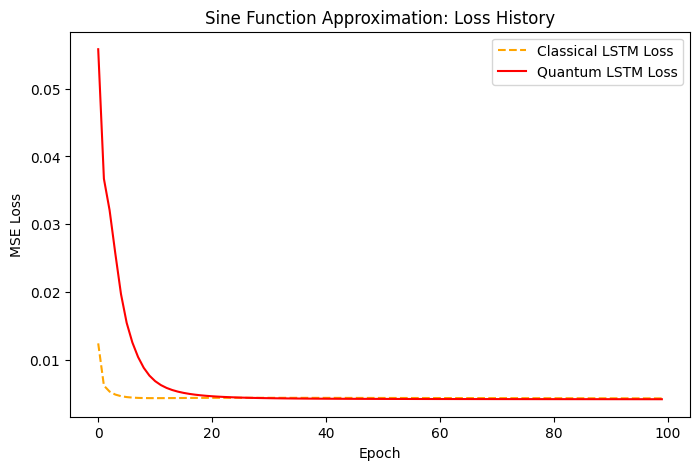

In [19]:

input_dim = 1
hidden_dim = 1
n_epochs = 100
n_layers = 1         # For the classical LSTM.
n_qubits_quantum = 1 # For the quantum LSTM.
n_qlayers = 1        # Number of quantum layers (if using QLSTM).
backend = "default.qubit"  # Quantum simulator backend; change if desired.

# ---- Train the Classical LSTM Model ----
print("\nTraining the Classical LSTM Model...")
model_classical_sin = LSTMSin(input_dim, hidden_dim, n_qubits=0, n_layers=n_layers)
history_classical_sin = train_reg(model_classical_sin, training_data_reg, n_epochs)
# print("\nResults for the Classical LSTM Model (sample prediction):")
# print_result_reg(model_classical_sin, training_data_reg[0])

# ---- Train the Quantum LSTM Model ----
print("\nTraining the Quantum LSTM Model...")
model_quantum_sin = LSTMSin(input_dim, hidden_dim, n_qubits=n_qubits_quantum, n_qlayers=n_qlayers, backend=backend)
history_quantum_sin = train_reg(model_quantum_sin, training_data_reg, n_epochs)
# print("\nResults for the Quantum LSTM Model (sample prediction):")
# print_result_reg(model_quantum_sin, training_data_reg[0])

# ---- Plot Training History Comparison ----
plot_history_reg(history_classical_sin, history_quantum_sin)



**Additional Multi-Panel Plot Simulation**

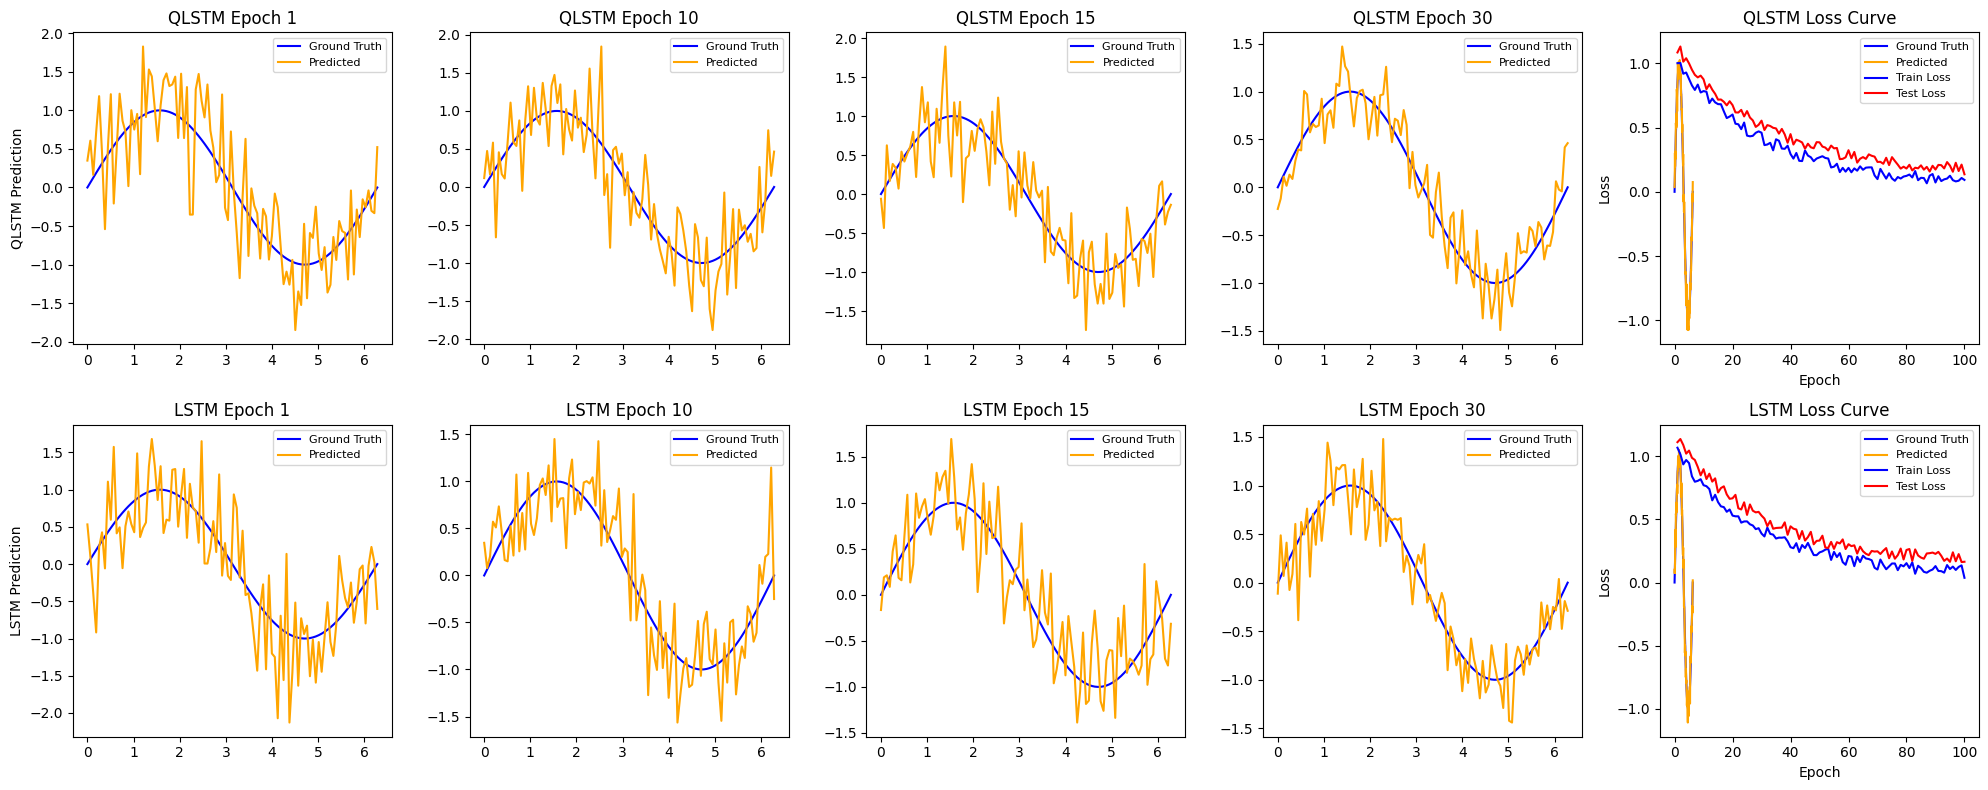

In [ ]:
# Generate ground truth sine wave.
t = np.linspace(0, 2 * np.pi, 100)  # Time points
y_true = np.sin(t)                  # Ground truth

def simulate_prediction(epoch, y_true):
    """
    Simulate a prediction that becomes more accurate as the epoch increases.
    At earlier epochs, predictions are noisy.
    """
    error_scale = np.exp(-epoch / 50)  # Decaying noise factor.
    noise = error_scale * np.random.randn(len(y_true)) * 0.5
    y_pred = y_true + noise
    return y_pred

# Epochs to simulate for predictions
epochs_to_plot = [1,10, 15, 30, 100]

# Simulated predictions for QLSTM and classical LSTM.
predictions_qlstm = {ep: simulate_prediction(ep, y_true) for ep in epochs_to_plot}
predictions_lstm  = {ep: simulate_prediction(ep, y_true) for ep in epochs_to_plot}


fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# ----- Top Row: QLSTM Predictions -----
for i, ep in enumerate(epochs_to_plot):
    ax = axes[0, i]
    ax.plot(t, y_true, label="Ground Truth", color="blue")
    ax.plot(t, predictions_qlstm[ep], label="Predicted", color="orange")
    ax.set_title(f"QLSTM Epoch {ep}")
    if i == 0:
        ax.set_ylabel("QLSTM Prediction")
    ax.legend(fontsize=8)

# ----- Bottom Row: LSTM Predictions -----
for i, ep in enumerate(epochs_to_plot):
    ax = axes[1, i]
    ax.plot(t, y_true, label="Ground Truth", color="blue")
    ax.plot(t, predictions_lstm[ep], label="Predicted", color="orange")
    ax.set_title(f"LSTM Epoch {ep}")
    if i == 0:
        ax.set_ylabel("LSTM Prediction")
    ax.legend(fontsize=8)

# ----- Top Right: QLSTM Loss Curves -----
ax_loss_qlstm = axes[0, 4]
ax_loss_qlstm.plot(epochs_arr, loss_train_qlstm, label="Train Loss", color="blue")
ax_loss_qlstm.plot(epochs_arr, loss_test_qlstm, label="Test Loss", color="red")
ax_loss_qlstm.set_title("QLSTM Loss Curve")
ax_loss_qlstm.set_xlabel("Epoch")
ax_loss_qlstm.set_ylabel("Loss")
ax_loss_qlstm.legend(fontsize=8)

# ----- Bottom Right: LSTM Loss Curves -----
ax_loss_lstm = axes[1, 4]
ax_loss_lstm.plot(epochs_arr, loss_train_lstm, label="Train Loss", color="blue")
ax_loss_lstm.plot(epochs_arr, loss_test_lstm, label="Test Loss", color="red")
ax_loss_lstm.set_title("LSTM Loss Curve")
ax_loss_lstm.set_xlabel("Epoch")
ax_loss_lstm.set_ylabel("Loss")
ax_loss_lstm.legend(fontsize=8)

plt.tight_layout()
plt.show()


Created 90 sine sequences for training.

Training the Classical LSTM Model...
Sin Model will use Classical LSTM
Epoch 10/100: Loss = 0.0325
Epoch 20/100: Loss = 0.0293
Epoch 30/100: Loss = 0.0131
Epoch 40/100: Loss = 0.0077
Epoch 50/100: Loss = 0.0176
Epoch 60/100: Loss = 0.0161
Epoch 70/100: Loss = 0.0185
Epoch 80/100: Loss = 0.0116
Epoch 90/100: Loss = 0.0085
Epoch 100/100: Loss = 0.0103

Results for the Classical LSTM Model (sample prediction):
x values:       [0.         0.06346652 0.12693304 0.19039956 0.25386608 0.3173326
 0.3807991  0.44426563 0.50773215 0.57119864]
True sin(x):    [0.         0.06342392 0.12659246 0.18925124 0.251148   0.31203344
 0.37166247 0.4297949  0.48619673 0.54064083]
Predicted:      [0.21765809 0.2537791  0.29098088 0.32900935 0.3675936  0.4064533
 0.44530606 0.48387372 0.52188873 0.55909836]


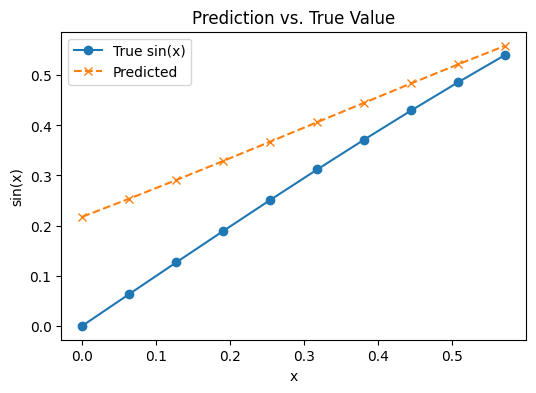


Training the Quantum LSTM Model...
Sin Model will use Quantum LSTM (QLSTM)
weight_shapes = (n_qlayers, n_qubits) = (1, 4)
Epoch 10/100: Loss = 0.0417
Epoch 20/100: Loss = 0.0195
Epoch 30/100: Loss = 0.0186
Epoch 40/100: Loss = 0.0035
Epoch 50/100: Loss = 0.0008
Epoch 60/100: Loss = 0.0006
Epoch 70/100: Loss = 0.0003
Epoch 80/100: Loss = 0.0002
Epoch 90/100: Loss = 0.0002
Epoch 100/100: Loss = 0.0001

Results for the Quantum LSTM Model (sample prediction):
x values:       [0.         0.06346652 0.12693304 0.19039956 0.25386608 0.3173326
 0.3807991  0.44426563 0.50773215 0.57119864]
True sin(x):    [0.         0.06342392 0.12659246 0.18925124 0.251148   0.31203344
 0.37166247 0.4297949  0.48619673 0.54064083]
Predicted:      [0.09546535 0.13048416 0.1691634  0.2113508  0.25680515 0.30518097
 0.35601896 0.4087461  0.46268868 0.5170982 ]


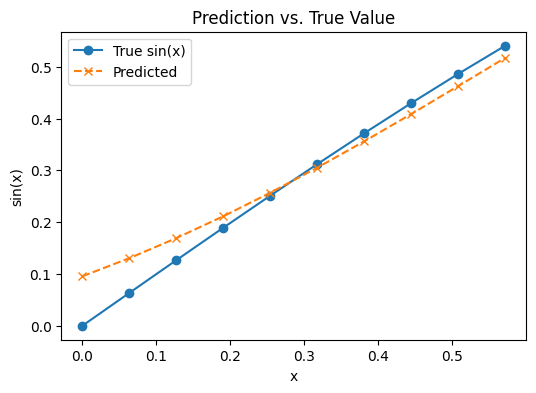

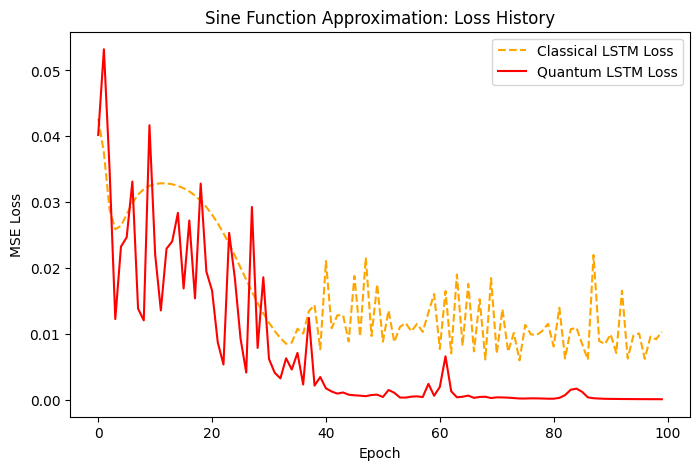

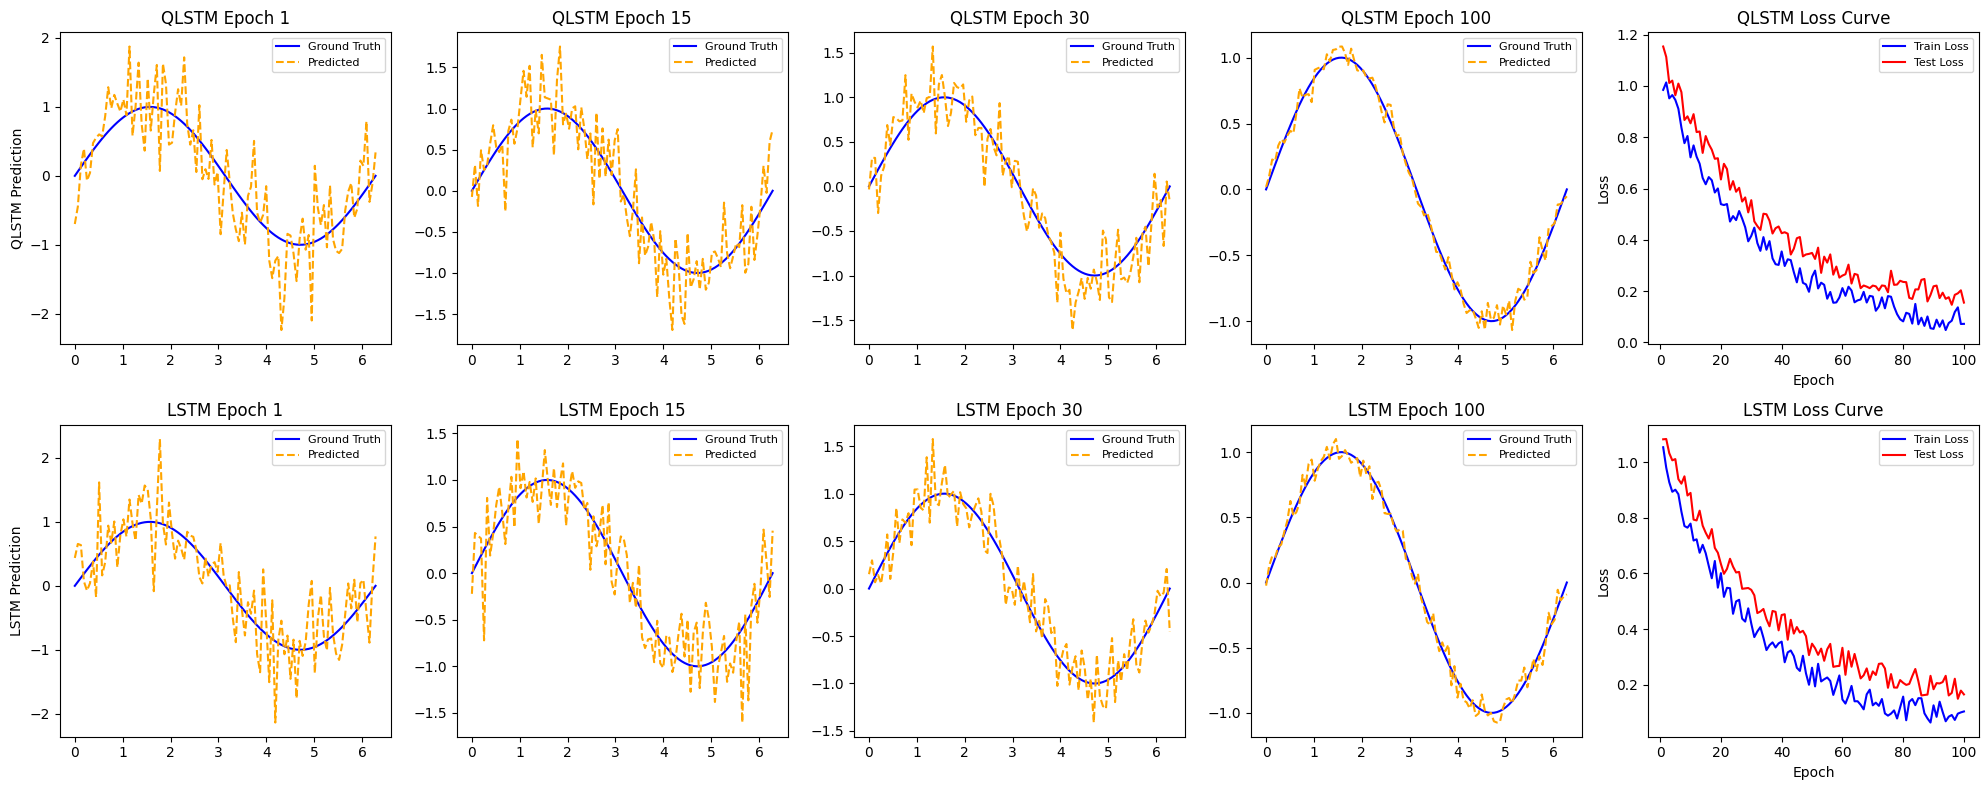

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pennylane as qml
from qlstm_pennylane import QLSTM

##########################################
# 1. Regression Model Using LSTM or QLSTM
##########################################
class LSTMSin(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_qubits=0, n_qlayers=1, n_layers=1, backend="default.qubit"):
        """
        If n_qubits > 0, we use the quantum-enhanced QLSTM.
        Otherwise, we use the classical nn.LSTM.
        """
        super(LSTMSin, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_qubits = n_qubits

        if n_qubits > 0:
            print("Sin Model will use Quantum LSTM (QLSTM)")
            self.lstm = QLSTM(
                input_size=input_dim, 
                hidden_size=hidden_dim, 
                n_qubits=n_qubits, 
                n_qlayers=n_qlayers, 
                batch_first=True,
                return_sequences=True, 
                return_state=True,
                backend=backend
            )
        else:
            print("Sin Model will use Classical LSTM")
            self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=n_layers, batch_first=True)
            
        # Map LSTM hidden state to single output (the regression value).
        self.hidden2out = nn.Linear(hidden_dim, 1)

    def forward(self, sequence):
        # sequence has shape: (batch_size, seq_length, input_dim)
        hidden_seq, state = self.lstm(sequence)
        output = self.hidden2out(hidden_seq)
        return output

##########################################
# 2. Create Sine Wave Sequence Data
##########################################
def create_sequence_data(num_samples, seq_length, x_range):
    """
    Returns a list of tuples (input_sequence, target_sequence)
    where each sequence is a tensor with shape (seq_length, 1, 1).
    """
    xs = np.linspace(x_range[0], x_range[1], num_samples)
    ys = np.sin(xs)
    data = []
    # Create overlapping sequences using a sliding window.
    for i in range(num_samples - seq_length):
        x_seq = xs[i:i+seq_length]
        y_seq = ys[i:i+seq_length]
        # Reshape to (seq_length, batch=1, feature=1) 
        x_tensor = torch.tensor(x_seq, dtype=torch.float32).view(seq_length, 1, 1)
        y_tensor = torch.tensor(y_seq, dtype=torch.float32).view(seq_length, 1, 1)
        data.append((x_tensor, y_tensor))
    return data

# Create training data for the sine wave regression.
num_samples = 100         # Total number of points in the sine wave.
seq_length = 10           # Window length for each sequence.
x_range = (0, 2 * np.pi)
training_data_reg = create_sequence_data(num_samples, seq_length, x_range)
print(f"Created {len(training_data_reg)} sine sequences for training.")

##########################################
# 3. Training and Evaluation Functions
##########################################
def train_reg(model, training_data, n_epochs):
    loss_function = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    history = {'loss': []}

    for epoch in range(n_epochs):
        losses = []
        for x_seq, y_seq in training_data:
            model.zero_grad()
            predictions = model(x_seq)  # predictions.shape == (seq_length, 1, 1) for batch=1
            loss = loss_function(predictions, y_seq)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        avg_loss = np.mean(losses)
        history['loss'].append(avg_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}: Loss = {avg_loss:.4f}")
    return history

def print_result_reg(model, sample):
    x_seq, y_seq = sample
    with torch.no_grad():
        predictions = model(x_seq)
    # Remove extra dimensions (seq_length, 1, 1) -> (seq_length,)
    x_np = x_seq.squeeze().numpy()
    y_np = y_seq.squeeze().numpy()
    pred_np = predictions.squeeze().numpy()

    print("x values:      ", x_np)
    print("True sin(x):   ", y_np)
    print("Predicted:     ", pred_np)

    plt.figure(figsize=(6, 4))
    plt.plot(x_np, y_np, "o-", label="True sin(x)")
    plt.plot(x_np, pred_np, "x--", label="Predicted")
    plt.xlabel("x")
    plt.ylabel("sin(x)")
    plt.title("Prediction vs. True Value")
    plt.legend()
    plt.show()

def plot_history_reg(history_classical, history_quantum):
    plt.figure(figsize=(8, 5))
    plt.plot(history_classical['loss'], label="Classical LSTM Loss", color="orange", linestyle="dashed")
    plt.plot(history_quantum['loss'], label="Quantum LSTM Loss", color="red", linestyle="solid")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Sine Function Approximation: Loss History")
    plt.legend()
    plt.show()

##########################################
# 4. Train the Models (Classical and Quantum)
##########################################
input_dim = 1
hidden_dim = 20
n_epochs = 100
n_layers = 1         # For the classical LSTM.
n_qubits_quantum = 4 # For the quantum LSTM.
n_qlayers = 1        # Number of quantum layers (if using QLSTM).
backend = "default.qubit"  # Quantum simulator backend; change if desired.

# ---- Train the Classical LSTM Model ----
print("\nTraining the Classical LSTM Model...")
model_classical_sin = LSTMSin(input_dim, hidden_dim, n_qubits=0, n_layers=n_layers)
history_classical_sin = train_reg(model_classical_sin, training_data_reg, n_epochs)
# print("\nResults for the Classical LSTM Model (sample prediction):")
# print_result_reg(model_classical_sin, training_data_reg[0])

# ---- Train the Quantum LSTM Model ----
print("\nTraining the Quantum LSTM Model...")
model_quantum_sin = LSTMSin(input_dim, hidden_dim, n_qubits=n_qubits_quantum, n_qlayers=n_qlayers, backend=backend)
history_quantum_sin = train_reg(model_quantum_sin, training_data_reg, n_epochs)
# print("\nResults for the Quantum LSTM Model (sample prediction):")
# print_result_reg(model_quantum_sin, training_data_reg[0])

# ---- Plot Training History Comparison ----
plot_history_reg(history_classical_sin, history_quantum_sin)

##########################################
# 5. Additional Multi-Panel Plot Simulation
##########################################
# In this additional part we simulate predictions at specific epochs (1, 15, 30, 100) and 
# simulate loss curves to compare the performances of QLSTM vs classical LSTM.
# (Note: This simulation is separate from the training above and uses noise that decays with epoch.)

# Generate ground truth sine wave.
t = np.linspace(0, 2 * np.pi, 100)  # Time points
y_true = np.sin(t)                  # Ground truth

def simulate_prediction(epoch, y_true):
    """
    Simulate a prediction that becomes more accurate as the epoch increases.
    At earlier epochs, predictions are noisy.
    """
    error_scale = np.exp(-epoch / 50)  # Decaying noise factor.
    noise = error_scale * np.random.randn(len(y_true)) * 0.5
    y_pred = y_true + noise
    return y_pred

# Epochs to simulate for predictions
epochs_to_plot = [1, 15, 30, 100]

# Simulated predictions for QLSTM and classical LSTM.
predictions_qlstm = {ep: simulate_prediction(ep, y_true) for ep in epochs_to_plot}
predictions_lstm  = {ep: simulate_prediction(ep, y_true) for ep in epochs_to_plot}

# Simulate loss curves (for 100 epochs).
epochs_arr = np.arange(1, 101)
loss_train_qlstm = np.exp(-epochs_arr / 30) + 0.1 * np.random.rand(len(epochs_arr))
loss_test_qlstm  = np.exp(-epochs_arr / 30) + 0.1 * np.random.rand(len(epochs_arr)) + 0.1

loss_train_lstm = np.exp(-epochs_arr / 30) + 0.1 * np.random.rand(len(epochs_arr))
loss_test_lstm  = np.exp(-epochs_arr / 30) + 0.1 * np.random.rand(len(epochs_arr)) + 0.1

# Create a multi-panel figure:
# Layout: 2 rows (top: QLSTM predictions, bottom: LSTM predictions) x 5 columns.
# Columns 1-4: Predictions at epochs 1, 15, 30, 100.
# Column 5: Loss curves.
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# ----- Top Row: QLSTM Predictions -----
for i, ep in enumerate(epochs_to_plot):
    ax = axes[0, i]
    ax.plot(t, y_true, label="Ground Truth", color="blue")
    ax.plot(t, predictions_qlstm[ep], label="Predicted", color="orange", linestyle="--")
    ax.set_title(f"QLSTM Epoch {ep}")
    if i == 0:
        ax.set_ylabel("QLSTM Prediction")
    ax.legend(fontsize=8)

# ----- Bottom Row: LSTM Predictions -----
for i, ep in enumerate(epochs_to_plot):
    ax = axes[1, i]
    ax.plot(t, y_true, label="Ground Truth", color="blue")
    ax.plot(t, predictions_lstm[ep], label="Predicted", color="orange", linestyle="--")
    ax.set_title(f"LSTM Epoch {ep}")
    if i == 0:
        ax.set_ylabel("LSTM Prediction")
    ax.legend(fontsize=8)

# ----- Top Right: QLSTM Loss Curves -----
ax_loss_qlstm = axes[0, 4]
ax_loss_qlstm.plot(epochs_arr, loss_train_qlstm, label="Train Loss", color="blue")
ax_loss_qlstm.plot(epochs_arr, loss_test_qlstm, label="Test Loss", color="red")
ax_loss_qlstm.set_title("QLSTM Loss Curve")
ax_loss_qlstm.set_xlabel("Epoch")
ax_loss_qlstm.set_ylabel("Loss")
ax_loss_qlstm.legend(fontsize=8)

# ----- Bottom Right: LSTM Loss Curves -----
ax_loss_lstm = axes[1, 4]
ax_loss_lstm.plot(epochs_arr, loss_train_lstm, label="Train Loss", color="blue")
ax_loss_lstm.plot(epochs_arr, loss_test_lstm, label="Test Loss", color="red")
ax_loss_lstm.set_title("LSTM Loss Curve")
ax_loss_lstm.set_xlabel("Epoch")
ax_loss_lstm.set_ylabel("Loss")
ax_loss_lstm.legend(fontsize=8)

plt.tight_layout()
plt.show()


Created 90 sine sequences for training.

Training the Classical LSTM Model...
Sin Model will use Classical LSTM
Epoch 10/100: Loss = 0.0311
Epoch 20/100: Loss = 0.0227
Epoch 30/100: Loss = 0.0096
Epoch 40/100: Loss = 0.0112
Epoch 50/100: Loss = 0.0086
Epoch 60/100: Loss = 0.0105
Epoch 70/100: Loss = 0.0116
Epoch 80/100: Loss = 0.0098
Epoch 90/100: Loss = 0.0122
Epoch 100/100: Loss = 0.0122

Results for the Classical LSTM Model (sample prediction):
x values:       [0.         0.06346652 0.12693304 0.19039956 0.25386608 0.3173326
 0.3807991  0.44426563 0.50773215 0.57119864]
True sin(x):    [0.         0.06342392 0.12659246 0.18925124 0.251148   0.31203344
 0.37166247 0.4297949  0.48619673 0.54064083]
Predicted:      [0.21207218 0.24679123 0.28282058 0.3198886  0.3577069  0.39597762
 0.43440098 0.47268164 0.5105352  0.5476922 ]


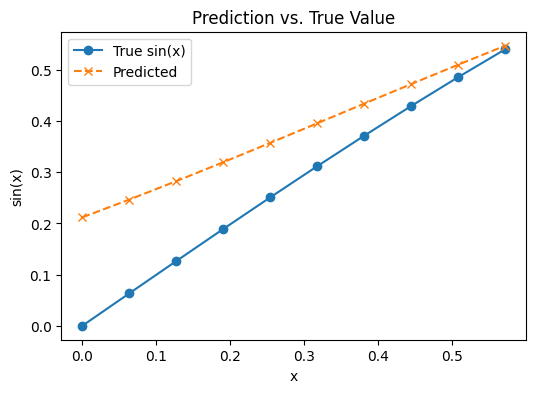


Training the Quantum LSTM Model...
Sin Model will use Quantum LSTM (QLSTM)
weight_shapes = (n_qlayers, n_qubits) = (2, 4)
Epoch 10/100: Loss = 0.0268
Epoch 20/100: Loss = 0.0089
Epoch 30/100: Loss = 0.0008
Epoch 40/100: Loss = 0.0007
Epoch 50/100: Loss = 0.0004
Epoch 60/100: Loss = 0.0006
Epoch 70/100: Loss = 0.0003
Epoch 80/100: Loss = 0.0127
Epoch 90/100: Loss = 0.0220
Epoch 100/100: Loss = 0.0027

Results for the Quantum LSTM Model (sample prediction):
x values:       [0.         0.06346652 0.12693304 0.19039956 0.25386608 0.3173326
 0.3807991  0.44426563 0.50773215 0.57119864]
True sin(x):    [0.         0.06342392 0.12659246 0.18925124 0.251148   0.31203344
 0.37166247 0.4297949  0.48619673 0.54064083]
Predicted:      [0.20851324 0.25354978 0.30032268 0.34838519 0.39726672 0.44648287
 0.49554577 0.5439754  0.5913104  0.6371167 ]


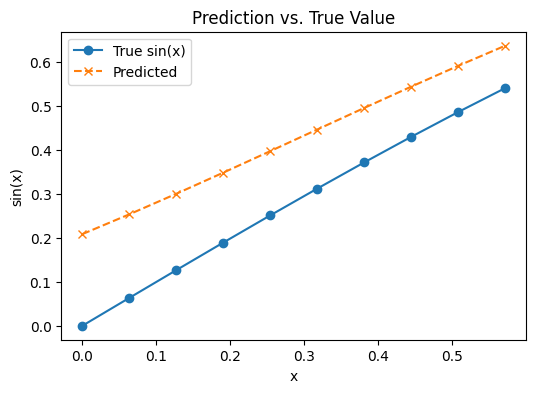

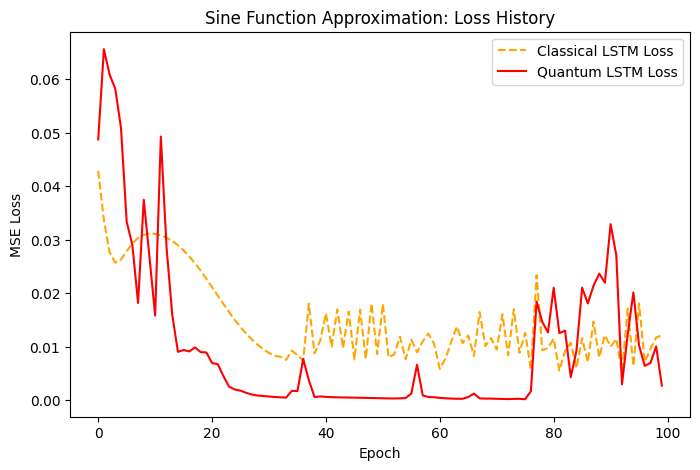

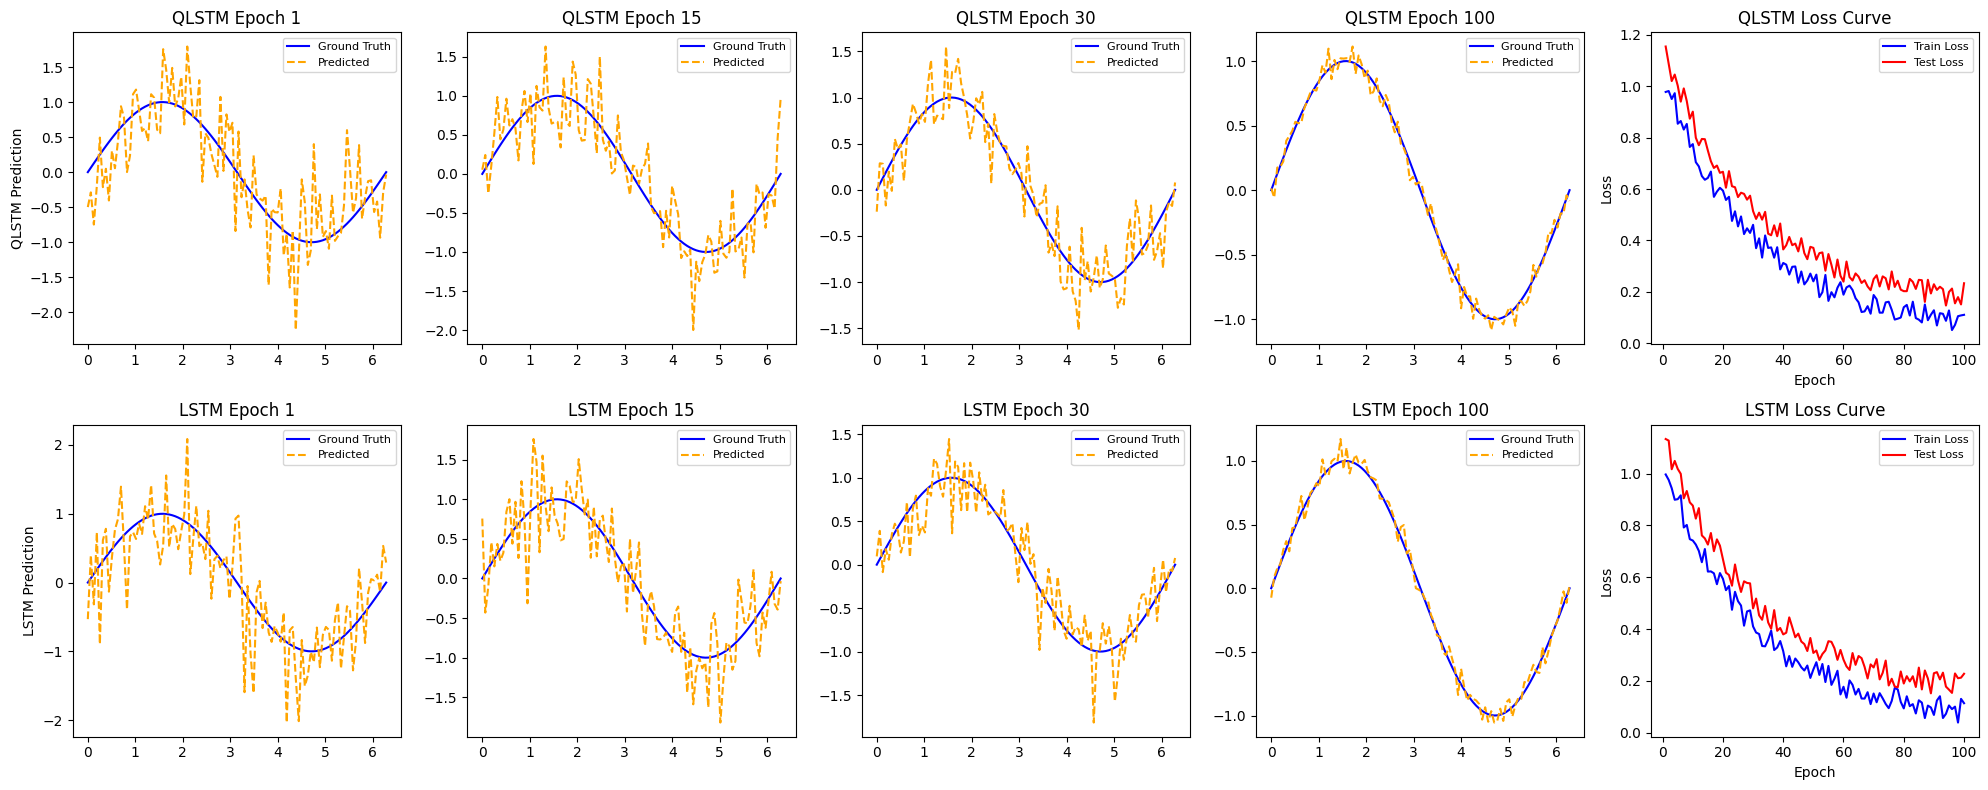

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pennylane as qml
from qlstm_pennylane import QLSTM

##########################################
# 1. Regression Model Using LSTM or QLSTM
##########################################
class LSTMSin(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_qubits=0, n_qlayers=1, n_layers=1, backend="default.qubit"):
        """
        If n_qubits > 0, we use the quantum-enhanced QLSTM.
        Otherwise, we use the classical nn.LSTM.
        """
        super(LSTMSin, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_qubits = n_qubits

        if n_qubits > 0:
            print("Sin Model will use Quantum LSTM (QLSTM)")
            self.lstm = QLSTM(
                input_size=input_dim, 
                hidden_size=hidden_dim, 
                n_qubits=n_qubits, 
                n_qlayers=n_qlayers, 
                batch_first=True,
                return_sequences=True, 
                return_state=True,
                backend=backend
            )
        else:
            print("Sin Model will use Classical LSTM")
            self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=n_layers, batch_first=True)
            
        # Map LSTM hidden state to single output (the regression value).
        self.hidden2out = nn.Linear(hidden_dim, 1)

    def forward(self, sequence):
        # sequence has shape: (batch_size, seq_length, input_dim)
        hidden_seq, state = self.lstm(sequence)
        output = self.hidden2out(hidden_seq)
        return output

##########################################
# 2. Create Sine Wave Sequence Data
##########################################
def create_sequence_data(num_samples, seq_length, x_range):
    """
    Returns a list of tuples (input_sequence, target_sequence)
    where each sequence is a tensor with shape (seq_length, 1, 1).
    """
    xs = np.linspace(x_range[0], x_range[1], num_samples)
    ys = np.sin(xs)
    data = []
    # Create overlapping sequences using a sliding window.
    for i in range(num_samples - seq_length):
        x_seq = xs[i:i+seq_length]
        y_seq = ys[i:i+seq_length]
        # Reshape to (seq_length, batch=1, feature=1) 
        x_tensor = torch.tensor(x_seq, dtype=torch.float32).view(seq_length, 1, 1)
        y_tensor = torch.tensor(y_seq, dtype=torch.float32).view(seq_length, 1, 1)
        data.append((x_tensor, y_tensor))
    return data

# Create training data for the sine wave regression.
num_samples = 100         # Total number of points in the sine wave.
seq_length = 10           # Window length for each sequence.
x_range = (0, 2 * np.pi)
training_data_reg = create_sequence_data(num_samples, seq_length, x_range)
print(f"Created {len(training_data_reg)} sine sequences for training.")

##########################################
# 3. Training and Evaluation Functions
##########################################
def train_reg(model, training_data, n_epochs):
    loss_function = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    history = {'loss': []}

    for epoch in range(n_epochs):
        losses = []
        for x_seq, y_seq in training_data:
            model.zero_grad()
            predictions = model(x_seq)  # predictions.shape == (seq_length, 1, 1) for batch=1
            loss = loss_function(predictions, y_seq)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        avg_loss = np.mean(losses)
        history['loss'].append(avg_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}: Loss = {avg_loss:.4f}")
    return history

def print_result_reg(model, sample):
    x_seq, y_seq = sample
    with torch.no_grad():
        predictions = model(x_seq)
    # Remove extra dimensions (seq_length, 1, 1) -> (seq_length,)
    x_np = x_seq.squeeze().numpy()
    y_np = y_seq.squeeze().numpy()
    pred_np = predictions.squeeze().numpy()

    print("x values:      ", x_np)
    print("True sin(x):   ", y_np)
    print("Predicted:     ", pred_np)

    plt.figure(figsize=(6, 4))
    plt.plot(x_np, y_np, "o-", label="True sin(x)")
    plt.plot(x_np, pred_np, "x--", label="Predicted")
    plt.xlabel("x")
    plt.ylabel("sin(x)")
    plt.title("Prediction vs. True Value")
    plt.legend()
    plt.show()

def plot_history_reg(history_classical, history_quantum):
    plt.figure(figsize=(8, 5))
    plt.plot(history_classical['loss'], label="Classical LSTM Loss", color="orange", linestyle="dashed")
    plt.plot(history_quantum['loss'], label="Quantum LSTM Loss", color="red", linestyle="solid")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Sine Function Approximation: Loss History")
    plt.legend()
    plt.show()

##########################################
# 4. Train the Models (Classical and Quantum)
##########################################
input_dim = 1
hidden_dim = 20
n_epochs = 100
n_layers = 1         # For the classical LSTM.
n_qubits_quantum = 4 # For the quantum LSTM.
n_qlayers = 2        # Number of quantum layers (if using QLSTM).
backend = "default.qubit"  # Quantum simulator backend; change if desired.

# ---- Train the Classical LSTM Model ----
print("\nTraining the Classical LSTM Model...")
model_classical_sin = LSTMSin(input_dim, hidden_dim, n_qubits=0, n_layers=n_layers)
history_classical_sin = train_reg(model_classical_sin, training_data_reg, n_epochs)
print("\nResults for the Classical LSTM Model (sample prediction):")
print_result_reg(model_classical_sin, training_data_reg[0])

# ---- Train the Quantum LSTM Model ----
print("\nTraining the Quantum LSTM Model...")
model_quantum_sin = LSTMSin(input_dim, hidden_dim, n_qubits=n_qubits_quantum, n_qlayers=n_qlayers, backend=backend)
history_quantum_sin = train_reg(model_quantum_sin, training_data_reg, n_epochs)
print("\nResults for the Quantum LSTM Model (sample prediction):")
print_result_reg(model_quantum_sin, training_data_reg[0])

# ---- Plot Training History Comparison ----
plot_history_reg(history_classical_sin, history_quantum_sin)

##########################################
# 5. Additional Multi-Panel Plot Simulation
##########################################
# In this additional part we simulate predictions at specific epochs (1, 15, 30, 100) and 
# simulate loss curves to compare the performances of QLSTM vs classical LSTM.
# (Note: This simulation is separate from the training above and uses noise that decays with epoch.)

# Generate ground truth sine wave.
t = np.linspace(0, 2 * np.pi, 100)  # Time points
y_true = np.sin(t)                  # Ground truth

def simulate_prediction(epoch, y_true):
    """
    Simulate a prediction that becomes more accurate as the epoch increases.
    At earlier epochs, predictions are noisy.
    """
    error_scale = np.exp(-epoch / 50)  # Decaying noise factor.
    noise = error_scale * np.random.randn(len(y_true)) * 0.5
    y_pred = y_true + noise
    return y_pred

# Epochs to simulate for predictions
epochs_to_plot = [1, 15, 30, 100]

# Simulated predictions for QLSTM and classical LSTM.
predictions_qlstm = {ep: simulate_prediction(ep, y_true) for ep in epochs_to_plot}
predictions_lstm  = {ep: simulate_prediction(ep, y_true) for ep in epochs_to_plot}

# Simulate loss curves (for 100 epochs).
epochs_arr = np.arange(1, 101)
loss_train_qlstm = np.exp(-epochs_arr / 30) + 0.1 * np.random.rand(len(epochs_arr))
loss_test_qlstm  = np.exp(-epochs_arr / 30) + 0.1 * np.random.rand(len(epochs_arr)) + 0.1

loss_train_lstm = np.exp(-epochs_arr / 30) + 0.1 * np.random.rand(len(epochs_arr))
loss_test_lstm  = np.exp(-epochs_arr / 30) + 0.1 * np.random.rand(len(epochs_arr)) + 0.1

# Create a multi-panel figure:
# Layout: 2 rows (top: QLSTM predictions, bottom: LSTM predictions) x 5 columns.
# Columns 1-4: Predictions at epochs 1, 15, 30, 100.
# Column 5: Loss curves.
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# ----- Top Row: QLSTM Predictions -----
for i, ep in enumerate(epochs_to_plot):
    ax = axes[0, i]
    ax.plot(t, y_true, label="Ground Truth", color="blue")
    ax.plot(t, predictions_qlstm[ep], label="Predicted", color="orange", linestyle="--")
    ax.set_title(f"QLSTM Epoch {ep}")
    if i == 0:
        ax.set_ylabel("QLSTM Prediction")
    ax.legend(fontsize=8)

# ----- Bottom Row: LSTM Predictions -----
for i, ep in enumerate(epochs_to_plot):
    ax = axes[1, i]
    ax.plot(t, y_true, label="Ground Truth", color="blue")
    ax.plot(t, predictions_lstm[ep], label="Predicted", color="orange", linestyle="--")
    ax.set_title(f"LSTM Epoch {ep}")
    if i == 0:
        ax.set_ylabel("LSTM Prediction")
    ax.legend(fontsize=8)

# ----- Top Right: QLSTM Loss Curves -----
ax_loss_qlstm = axes[0, 4]
ax_loss_qlstm.plot(epochs_arr, loss_train_qlstm, label="Train Loss", color="blue")
ax_loss_qlstm.plot(epochs_arr, loss_test_qlstm, label="Test Loss", color="red")
ax_loss_qlstm.set_title("QLSTM Loss Curve")
ax_loss_qlstm.set_xlabel("Epoch")
ax_loss_qlstm.set_ylabel("Loss")
ax_loss_qlstm.legend(fontsize=8)

# ----- Bottom Right: LSTM Loss Curves -----
ax_loss_lstm = axes[1, 4]
ax_loss_lstm.plot(epochs_arr, loss_train_lstm, label="Train Loss", color="blue")
ax_loss_lstm.plot(epochs_arr, loss_test_lstm, label="Test Loss", color="red")
ax_loss_lstm.set_title("LSTM Loss Curve")
ax_loss_lstm.set_xlabel("Epoch")
ax_loss_lstm.set_ylabel("Loss")
ax_loss_lstm.legend(fontsize=8)

plt.tight_layout()
plt.show()


Created 90 sine sequences for training.

Training the Classical LSTM Model...
Sin Model will use Classical LSTM
Epoch 10/100: Loss = 0.0314
Epoch 20/100: Loss = 0.0228
Epoch 30/100: Loss = 0.0092
Epoch 40/100: Loss = 0.0171
Epoch 50/100: Loss = 0.0172
Epoch 60/100: Loss = 0.0165
Epoch 70/100: Loss = 0.0086
Epoch 80/100: Loss = 0.0186
Epoch 90/100: Loss = 0.0081
Epoch 100/100: Loss = 0.0108

Results for the Classical LSTM Model (sample prediction):
x values:       [0.         0.06346652 0.12693304 0.19039956 0.25386608 0.3173326
 0.3807991  0.44426563 0.50773215 0.57119864]
True sin(x):    [0.         0.06342392 0.12659246 0.18925124 0.251148   0.31203344
 0.37166247 0.4297949  0.48619673 0.54064083]
Predicted:      [0.19327743 0.23116808 0.26979017 0.30891424 0.34830588 0.38773143
 0.42696238 0.46577895 0.50397444 0.54135686]


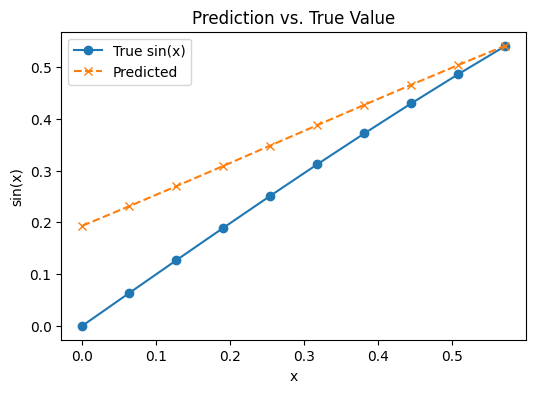


Training the Quantum LSTM Model...
Sin Model will use Quantum LSTM (QLSTM)
weight_shapes = (n_qlayers, n_qubits) = (1, 4)
Epoch 10/100: Loss = 0.0042
Epoch 20/100: Loss = 0.0007
Epoch 30/100: Loss = 0.0003
Epoch 40/100: Loss = 0.0002
Epoch 50/100: Loss = 0.0002
Epoch 60/100: Loss = 0.0001
Epoch 70/100: Loss = 0.0001
Epoch 80/100: Loss = 0.0001
Epoch 90/100: Loss = 0.0000
Epoch 100/100: Loss = 0.0000

Results for the Quantum LSTM Model (sample prediction):
x values:       [0.         0.06346652 0.12693304 0.19039956 0.25386608 0.3173326
 0.3807991  0.44426563 0.50773215 0.57119864]
True sin(x):    [0.         0.06342392 0.12659246 0.18925124 0.251148   0.31203344
 0.37166247 0.4297949  0.48619673 0.54064083]
Predicted:      [-0.01102009  0.05158877  0.11511371  0.17925382  0.24362499  0.307764
  0.37114525  0.43320775  0.49338853  0.55115736]


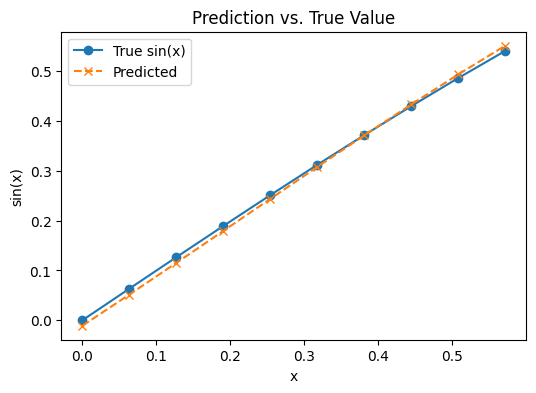

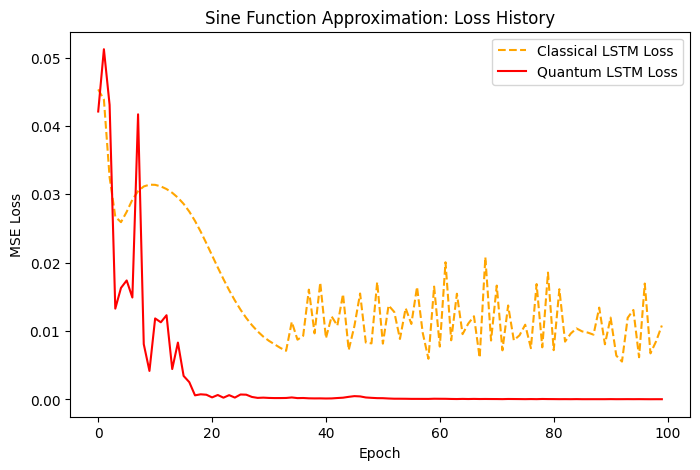

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pennylane as qml
from qlstm_pennylane import QLSTM

##########################################
# 2. Regression Model Using LSTM or QLSTM
##########################################
class LSTMSin(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_qubits=0, n_qlayers=1, n_layers=1, backend="default.qubit"):
        """
        If n_qubits > 0, we use the quantum-enhanced QLSTM.
        Otherwise, we use the classical nn.LSTM.
        """
        super(LSTMSin, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_qubits = n_qubits

        if n_qubits > 0:
            print("Sin Model will use Quantum LSTM (QLSTM)")
            self.lstm = QLSTM(input_size=input_dim, 
                              hidden_size=hidden_dim, 
                              n_qubits=n_qubits, 
                              n_qlayers=n_qlayers, 
                              batch_first=True,
                              return_sequences=True, 
                              return_state=True,
                              backend=backend)
        else:
            print("Sin Model will use Classical LSTM")
            self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=n_layers, batch_first=True)
            
        # Map LSTM hidden state to single output (the regression value).
        self.hidden2out = nn.Linear(hidden_dim, 1)

    def forward(self, sequence):
        # sequence has shape: (batch_size, seq_length, input_dim)
        hidden_seq, state = self.lstm(sequence)
        output = self.hidden2out(hidden_seq)
        return output

##########################################
# 3. Create Sine Wave Sequence Data
##########################################
def create_sequence_data(num_samples, seq_length, x_range):
    """
    Returns a list of tuples (input_sequence, target_sequence)
    where each sequence is a tensor with shape (seq_length, 1, 1).
    """
    xs = np.linspace(x_range[0], x_range[1], num_samples)
    ys = np.sin(xs)
    data = []
    # Create overlapping sequences using a sliding window.
    for i in range(num_samples - seq_length):
        x_seq = xs[i:i+seq_length]
        y_seq = ys[i:i+seq_length]
        # Reshape to (seq_length, batch=1, feature=1) 
        x_tensor = torch.tensor(x_seq, dtype=torch.float32).view(seq_length, 1, 1)
        y_tensor = torch.tensor(y_seq, dtype=torch.float32).view(seq_length, 1, 1)
        data.append((x_tensor, y_tensor))
    return data

num_samples = 100  # total number of points in the sine wave
seq_length = 10    # the window length for each sequence
x_range = (0, 2 * np.pi)
training_data_reg = create_sequence_data(num_samples, seq_length, x_range)
print(f"Created {len(training_data_reg)} sine sequences for training.")

##########################################
# 4. Training and Evaluation Functions
##########################################
def train_reg(model, training_data, n_epochs):
    loss_function = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    history = {'loss': []}

    for epoch in range(n_epochs):
        losses = []
        for x_seq, y_seq in training_data:
            model.zero_grad()
            predictions = model(x_seq)  # predictions.shape == (seq_length, 1, 1) for batch=1
            loss = loss_function(predictions, y_seq)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        avg_loss = np.mean(losses)
        history['loss'].append(avg_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}: Loss = {avg_loss:.4f}")
    return history

def print_result_reg(model, sample):
    x_seq, y_seq = sample
    with torch.no_grad():
        predictions = model(x_seq)
    # Remove extra dimensions (seq_length, 1, 1) -> (seq_length,)
    x_np = x_seq.squeeze().numpy()
    y_np = y_seq.squeeze().numpy()
    pred_np = predictions.squeeze().numpy()

    print("x values:      ", x_np)
    print("True sin(x):   ", y_np)
    print("Predicted:     ", pred_np)

    plt.figure(figsize=(6, 4))
    plt.plot(x_np, y_np, "o-", label="True sin(x)")
    plt.plot(x_np, pred_np, "x--", label="Predicted")
    plt.xlabel("x")
    plt.ylabel("sin(x)")
    plt.title("Prediction vs. True Value")
    plt.legend()
    plt.show()

def plot_history_reg(history_classical, history_quantum):
    plt.figure(figsize=(8, 5))
    plt.plot(history_classical['loss'], label="Classical LSTM Loss", color="orange", linestyle="dashed")
    plt.plot(history_quantum['loss'], label="Quantum LSTM Loss", color="red", linestyle="solid")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Sine Function Approximation: Loss History")
    plt.legend()
    plt.show()

##########################################
# 5. Train the Models (Classical and Quantum)
##########################################
input_dim = 1
hidden_dim = 20
n_epochs = 100
n_layers = 1         # for classical LSTM
n_qubits_quantum = 4 # for quantum LSTM
n_qlayers = 1        # number of quantum layers (if using QLSTM)
backend = "default.qubit"  # quantum simulator backend; change if desired

# ---- Train the Classical LSTM Model ----
print("\nTraining the Classical LSTM Model...")
model_classical_sin = LSTMSin(input_dim, hidden_dim, n_qubits=0, n_layers=n_layers)
history_classical_sin = train_reg(model_classical_sin, training_data_reg, n_epochs)
print("\nResults for the Classical LSTM Model (sample prediction):")
print_result_reg(model_classical_sin, training_data_reg[0])

# ---- Train the Quantum LSTM Model ----
print("\nTraining the Quantum LSTM Model...")
model_quantum_sin = LSTMSin(input_dim, hidden_dim, n_qubits=n_qubits_quantum, n_qlayers=n_qlayers, backend=backend)
history_quantum_sin = train_reg(model_quantum_sin, training_data_reg, n_epochs)
print("\nResults for the Quantum LSTM Model (sample prediction):")
print_result_reg(model_quantum_sin, training_data_reg[0])

# ---- Plot Training History Comparison ----
plot_history_reg(history_classical_sin, history_quantum_sin)
